In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## Synthetic time series example
Suppose a simple regression problem.

$$f(t) = \sin(0.01t) + 0.2 \epsilon, \quad \epsilon\sim\mathcal{N}(0,1), \quad t\in [0,1000]$$

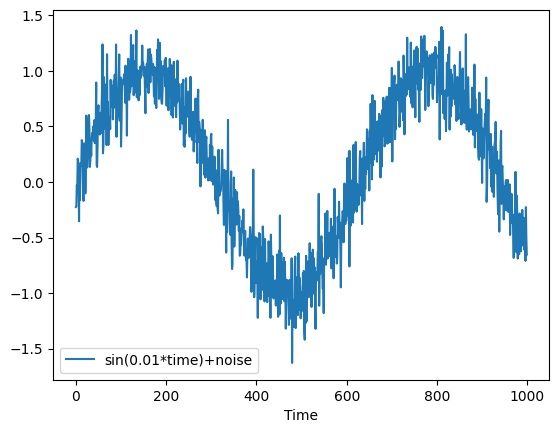

In [2]:
T = 1000
time = torch.arange(0.0, T)
X = torch.sin(0.01 * time) + 0.2 * torch.randn(T)
plt.plot(time.numpy(), X.numpy(), label="sin(0.01*time)+noise");
plt.legend();
plt.xlabel("Time");
plt.show()

## Recurrent Neural Networks
We use the following model.  
$$p(x_t|x_{t-1},...,x_1)≈p(x_t|x_{t-1},h_t)$$

Here $h_t$ is a latent variable that stores the sequence information:  
$$h_t=f(x,h_{t-1})$$

In [3]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(1, 10, batch_first=True)
        self.relu = nn.ReLU()
        self.final = nn.Linear(10, 1)

    def forward(self, inputs):
        outputs, hidden = self.rnn(inputs)
        outputs = outputs[:, -1, :]
        outputs = self.final(outputs)

        return outputs

## Train with RNN

In [4]:
# Hyperparameter
batch_size, train_number = 16, 600

# timestamp
tau = 4
features = torch.zeros((T-tau, tau, 1)) # RNN Model needs tau inputs: shape is (996, 4, 1)

for i in range(tau):
    features[:, i] = X[i:(T-tau + i)].reshape(-1, 1)

labels = X[tau:] # shape is (996, )

# Prepare DataLoader
train_data = TensorDataset(features[:train_number, :], labels[:train_number])
test_data = TensorDataset(features[train_number:, :], labels[train_number:])

In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam

def train_net(net, data, criterion, epochs, lr_rate):
    optim = optimizer(net.parameters(), lr=lr_rate)
    data_iter = DataLoader(data, batch_size, shuffle=True)

    for epoch in range(1, epochs+1):
        running_loss = 0.0
        
        for x, y in data_iter:
            optim.zero_grad()
            output = net(x)
            loss = criterion(output, y.reshape(-1, 1))
            loss.backward()
            optim.step()
            running_loss += loss.item()
        
        print("epoch: {}, loss: {:.2f}".format(epoch, running_loss))
    
    test_loss = criterion(net(test_data[:][0]), test_data[:][1].reshape(-1,1))
    print('test loss: %f' % test_loss.mean().detach().numpy())

    return net
    
net = RNN()
net = train_net(net, train_data, criterion, 10, 0.01)

epoch: 1, loss: 3.58
epoch: 2, loss: 2.48
epoch: 3, loss: 2.36
epoch: 4, loss: 2.18
epoch: 5, loss: 2.17
epoch: 6, loss: 2.13
epoch: 7, loss: 2.22
epoch: 8, loss: 2.53
epoch: 9, loss: 2.13
epoch: 10, loss: 2.12
test loss: 0.060098


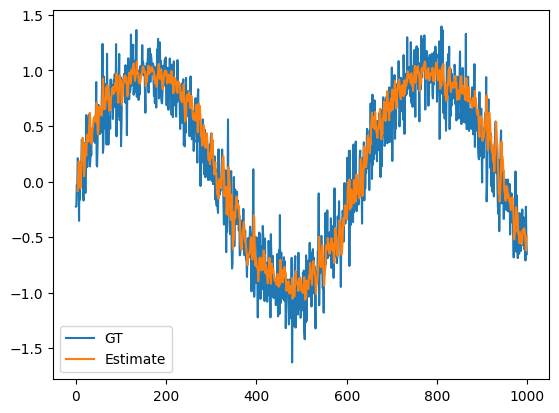

train loss: 0.05548696219921112
test loss: 0.060436129570007324


In [6]:
estimates = net(features)
plt.plot(time.numpy(), X.numpy(), label='GT')
plt.plot(time[tau:].numpy(), estimates.detach().numpy(), label='Estimate')
plt.legend()
plt.show()

train_estimate_loss = criterion(estimates[:train_number-tau].squeeze(), labels[:train_number-tau]).item()
test_estimate_loss = criterion(estimates[train_number-tau:].squeeze(), labels[train_number-tau:]).item()
print('train loss:', train_estimate_loss)
print('test loss:', test_estimate_loss)

## Why forecasting is not simple
In reality, for $t>600$, we cannot use $x_t$ in an autoregressive model. Instead we have to use predicted values $\hat{x}_t$ recursively:  
$$\hat{x}_{601} = f(x_{600},x_{599},x_{598},x_{597})$$
$$\hat{x}_{602} = f(\hat{x}_{601},x_{600},x_{599},x_{598})$$
$$\hat{x}_{603} = f(\hat{x}_{602},\hat{x}_{601},x_{600},x_{599})$$
$$\hat{x}_{604} = f(\hat{x}_{603},\hat{x}_{602},\hat{x}_{601},x_{600})$$

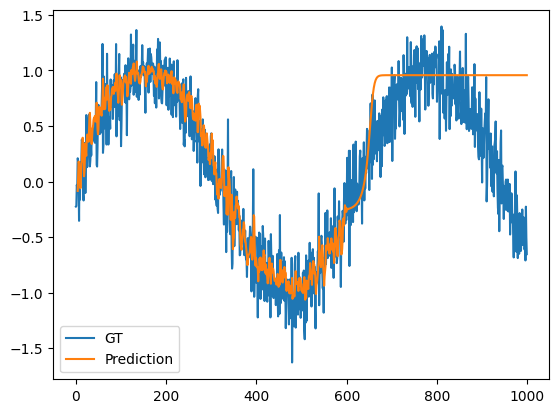

train loss: 0.05548696219921112
test loss: 0.3794845938682556


In [7]:
predictions = torch.zeros_like(estimates)
predictions[:(train_number - tau)] = estimates[:(train_number - tau)]

for i in range((train_number - tau), (T - tau)):
    predictions[i] = net(
        predictions[(i - tau):i].reshape(1, -1, 1)
    )

plt.plot(time.numpy(), X.numpy(), label='GT')
plt.plot(time[tau:].numpy(), predictions.detach().numpy(), label='Prediction')
plt.legend()
plt.show()

train_prediction_loss = criterion(predictions[:train_number-tau].squeeze(), labels[:train_number-tau]).item()
test_prediction_loss = criterion(predictions[train_number-tau:].squeeze(), labels[train_number-tau:]).item()
print('train loss:', train_prediction_loss)
print('test loss:', test_prediction_loss)

## TODO: Build your own RNN to improve forecasting

In [192]:
class MyRNN(nn.Module):
    def __init__(self):
        super(MyRNN, self).__init__()
        ######################
        # Implement here
        self.rnn = nn.LSTM(1, 10, 1, bidirectional=True, batch_first=True)
        self.final = nn.Linear(20, 1)

        ######################

    def forward(self, inputs):
        ######################
        # Implement here
        #inputs += torch.randn(inputs.shape)*0.1
        outputs, hidden = self.rnn(inputs)
        outputs = outputs[:, -1, :]
        outputs = self.final(outputs)

        outputs += inputs[:,-1,:] + (inputs[:,-1,:] - inputs[:,-2,:]) * torch.rand(1)
        #outputs += torch.randn(outputs.shape)*0.05
        ######################
        return outputs

## Train your RNN

In [193]:
T = 1000
time = torch.arange(0.0, T)
X = torch.sin(0.01 * time) #+ 0.2 * torch.randn(T)

# Hyperparameter
batch_size, train_number = 600, 600

# timestamp
tau = 4
features = torch.zeros((T-tau, tau, 1)) # RNN Model needs tau inputs: shape is (996, 4, 1)

for i in range(tau):
    features[:, i] = X[i:(T-tau + i)].reshape(-1, 1)

labels = X[tau:] # shape is (996, )

# Prepare DataLoader
train_data = TensorDataset(features[:train_number, :], labels[:train_number])
test_data = TensorDataset(features[train_number:, :], labels[train_number:])

# ===
# predict multi step

predict_num = 100
train_labels = torch.zeros((train_number, predict_num))
for i in range(predict_num):
    train_labels[:, i] = X[tau+i:tau+i + train_number]
train_data = TensorDataset(features[:train_number, :], train_labels[:train_number])

# ===

criterion = nn.MSELoss()
optimizer = torch.optim.Adam

def train_net(net, data, criterion, epochs, lr_rate):
    optim = optimizer(net.parameters(), lr=lr_rate, weight_decay=0.1)
    data_iter = DataLoader(data, batch_size, shuffle=True)

    for epoch in range(1, epochs+1):
        running_loss = 0.0
        
        for x, y in data_iter:
            optim.zero_grad()
            _batch = x.shape[0]
            inp = torch.zeros(_batch, tau+predict_num)
            inp[:,:tau] = x.reshape(_batch, -1)
            for i in range(predict_num):
                output = net(
                    inp[:,i:i+tau].reshape(_batch, -1, 1)
                )
                '''
                if (i % 4) != 0:
                  inp[:,i+tau:i+tau+1] = output.detach()
                else:
                  inp[:,i+tau:i+tau+1] = output
                '''
                inp[:,i+tau:i+tau+1] = output
                inp[:,i+tau:i+tau+1] += torch.randn(inp[:,i+tau:i+tau+1].shape)*0.2
            
            loss = criterion(inp[:,-1*predict_num:], y[:, :])
            #print(inp[0,:])
            #print(y[0,:])
            loss.backward()
            optim.step()
            running_loss += loss.item()
        
        print("epoch: {}, loss: {:.2f}".format(epoch, running_loss))
    
    test_loss = criterion(net(test_data[:][0]), test_data[:][1].reshape(-1,1))
    print('test loss: %f' % test_loss.mean().detach().numpy())

    return net

In [194]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

my_net = MyRNN()
my_net = train_net(my_net, train_data, criterion, 50, 0.01)

epoch: 1, loss: 4.97
epoch: 2, loss: 1.43
epoch: 3, loss: 1.14
epoch: 4, loss: 1.12
epoch: 5, loss: 1.17
epoch: 6, loss: 1.07
epoch: 7, loss: 1.10
epoch: 8, loss: 1.18
epoch: 9, loss: 0.93
epoch: 10, loss: 0.95
epoch: 11, loss: 0.85
epoch: 12, loss: 0.88
epoch: 13, loss: 0.88
epoch: 14, loss: 0.84
epoch: 15, loss: 0.81
epoch: 16, loss: 0.78
epoch: 17, loss: 0.77
epoch: 18, loss: 0.76
epoch: 19, loss: 0.78
epoch: 20, loss: 0.83
epoch: 21, loss: 0.75
epoch: 22, loss: 0.75
epoch: 23, loss: 0.78
epoch: 24, loss: 0.82
epoch: 25, loss: 0.79
epoch: 26, loss: 0.75
epoch: 27, loss: 0.76
epoch: 28, loss: 0.76
epoch: 29, loss: 0.78
epoch: 30, loss: 0.72
epoch: 31, loss: 0.75
epoch: 32, loss: 0.73
epoch: 33, loss: 0.83
epoch: 34, loss: 0.73
epoch: 35, loss: 0.76
epoch: 36, loss: 0.80
epoch: 37, loss: 0.75
epoch: 38, loss: 0.75
epoch: 39, loss: 0.78
epoch: 40, loss: 0.77
epoch: 41, loss: 0.78
epoch: 42, loss: 0.75
epoch: 43, loss: 0.73
epoch: 44, loss: 0.77
epoch: 45, loss: 0.76
epoch: 46, loss: 0.

## Test your RNN (Do not change this part)

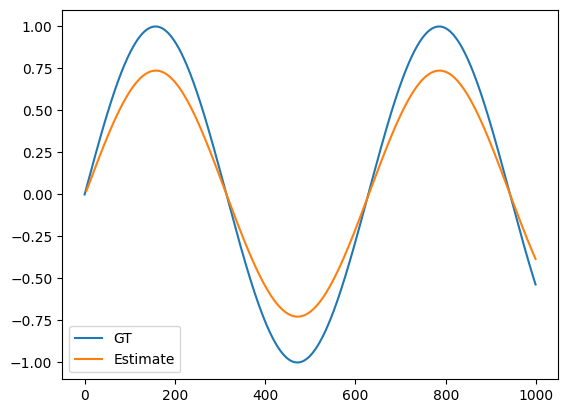

train loss: 0.03875040262937546
test loss: 0.0295808557420969


In [195]:
my_estimates = my_net(features)
plt.plot(time.numpy(), X.numpy(), label='GT')
plt.plot(time[tau:].numpy(), my_estimates.detach().numpy(), label='Estimate')
plt.legend()
plt.show()

my_train_estimate_loss = criterion(my_estimates[:train_number-tau].squeeze(), labels[:train_number-tau]).item()
my_test_estimate_loss = criterion(my_estimates[train_number-tau:].squeeze(), labels[train_number-tau:]).item()
print('train loss:', my_train_estimate_loss)
print('test loss:', my_test_estimate_loss)

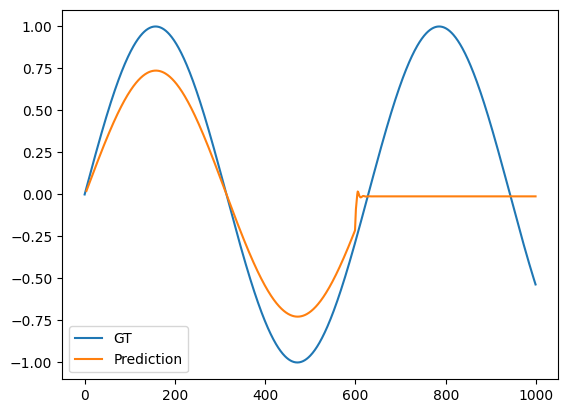

train loss: 0.03875040262937546
test loss: 0.4191775619983673


In [196]:
my_predictions = torch.zeros_like(my_estimates)
my_predictions[:(train_number - tau)] = my_estimates[:(train_number - tau)]

for i in range((train_number - tau), (T - tau)):
    my_predictions[i] = my_net(
        my_predictions[(i - tau):i].reshape(1, -1, 1)
    )

plt.plot(time.numpy(), X.numpy(), label='GT')
plt.plot(time[tau:].numpy(), my_predictions.detach().numpy(), label='Prediction')
plt.legend()
plt.show()

my_train_prediction_loss = criterion(my_predictions[:train_number-tau].squeeze(), labels[:train_number-tau]).item()
my_test_prediction_loss = criterion(my_predictions[train_number-tau:].squeeze(), labels[train_number-tau:]).item()
print('train loss:', my_train_prediction_loss)
print('test loss:', my_test_prediction_loss)